In [462]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [476]:
start_year = 1700
end_year = 2019
year_list = list(range(start_year, end_year))

In [477]:
def load_pretrained_glove(file):
    print("Loading")
    model = {}
    f = open(file, 'r')
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print(len(model),"words loaded")
    return model

In [478]:
def get_entity_from_txt(year):
    entities = []
    with open("dataset/original/wikipedia/wikipedia/" + year + ".txt", 'r') as f:
        event_section = "".join(f.readlines()).split("Births")[0]
        for line in event_section.split():
            entities.extend([word for word in line.split() if word.find("C_") == 0 and word.find("C_D_") == -1])
    return entities

In [479]:
def get_avg_embedding(embeddings):
    avg_embedding = np.average(embeddings, axis=0)
    rounded_avg_embedding = [round(val, 6) for val in avg_embedding.tolist()]
    return rounded_avg_embedding

In [480]:
def get_year_embedding(entities, model): # 1 year embedding
    embeddings = []
    for entity in entities:
        untagged_entity = entity.split('_')[2].lower()
        try:
            embeddings.append(model[untagged_entity])
#             print(untagged_entity)
        except Exception as e:
            continue
    year_embedding = get_avg_embedding(embeddings)
#     print("-> glove에 존재하는 word 개수:", len(embeddings))
    return year_embedding

In [481]:
def get_year_embeddings(): # year embedding list
    year_embeddings = []
    appended_year = []
    for year in year_list:
        year = str(year)
        try:
            entities = set(get_entity_from_txt(year))
#             print(year)
            appended_year.append(year)
#             print("-> entity 개수: ",len(entities))
            year_embedding = get_year_embedding(entities, model)
            year_embeddings.append(year_embedding)

    #         write_time_embedding(year, year_embedding)
        except Exception as e:
            continue
    return year_embeddings, appended_year

In [482]:
def get_years_embeddings(year_embeddings, appended_year, unit_num): # years embedding list by unit
    years = 0
    tmp_year_embeddings = []
    years_embeddings = []
    appended_years = []

    for i in range(len(appended_year)):
        tmp_years = int(int(appended_year[i]) / unit_num) * unit_num
        if(years != tmp_years):
            if(len(tmp_year_embeddings) != 0): # not first data
                avg_embedding = get_avg_embedding(tmp_year_embeddings)
                years_embeddings.append(avg_embedding)
                appended_years.append(str(years) + 's' if(unit_num == 10) else str(int(years / unit_num)) + 'th')
            years = tmp_years
            tmp_year_embeddings = []
            
        tmp_year_embeddings.append(year_embeddings[i])

        if((i+1) == len(appended_year)): # last data
            avg_embedding = get_avg_embedding(tmp_year_embeddings)
            years_embeddings.append(avg_embedding)
            appended_years.append(str(years) + 's' if(unit_num == 10) else str(int(years / unit_num)) + 'th')
    #     print(i, appended_years[i], year)
#     print(len(years_embeddings))
    return years_embeddings, appended_years

In [483]:
def write_time_embedding(year, time_embedding):
    with open('dataset/time-embedding.txt', 'a') as f:
        embed_to_txt = ' '.join(map(str, time_embedding))
        f.write(year + ' ' + embed_to_txt + '\n')

In [445]:
model = load_pretrained_glove("dataset/original/glove.6B.300d.txt")

Loading
400000 words loaded


In [484]:
year_embeddings, appended_year = get_year_embeddings()
decade_embeddings, appended_decade = get_years_embeddings(year_embeddings, appended_year, 10)
century_embeddings, appended_century = get_years_embeddings(year_embeddings, appended_year, 100)

In [485]:
time_embeddings = []
time_list = []
time_embeddings.extend(year_embeddings)
time_embeddings.extend(decade_embeddings)
time_embeddings.extend(century_embeddings)
time_list.extend(appended_year)
time_list.extend(appended_decade)
time_list.extend(appended_century)

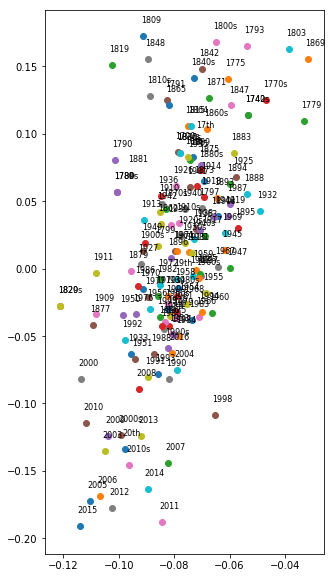

In [487]:
# Visualization
pca = PCA(n_components=2)
pca.fit(np.array(time_embeddings).transpose())
plt.figure(figsize=(5, 10))
for i in range(len(pca.components_[0])):
    plt.scatter(pca.components_[0][i], pca.components_[1][i])
    plt.text(pca.components_[0][i] - 0.001, pca.components_[1][i] + 0.01, time_list[i], fontsize=8)